# Note before you run

#### This lab will run UDFs on training a tensorflow model, save model in kinetca database, using that model for inference. Prerequisites include using UDF, knowledge of Tensorflow, deep learning.



If you run into errors like CUDA out of memory, you may need to 
change <font color='green'>os.environ["CUDA_VISIBLE_DEVICES"]="0"</font> from 0 to the index 
of gpu which has enough memory. If all your gpus memory are full, 
then try to use <font color='green'>os.environ["CUDA_VISIBLE_DEVICES"]=""</font> to force 
tensorflow to use CPU 

When traing a model, make sure <font color='green'>ModelName</font> is not existing in TFmodel table.
For example, if you trained with <font color='green'>ModelName='TF1.ckpt'</font>. Then next time, you run the 
training, you need to change  <font color='green'>ModelName='OtherName.ckpt'</font>.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url=r"""https://docs.google.com/drawings/d/e/2PAC
X-1vQRoGhcQ_iJpRxynriYMCUVfcN5Q49KdiifO5ek3ZC21V6Az5gP8Wi
4AaBp3TGNCknCMgdkF8j2pIt8/pub?w=802&h=271""".replace("\n",""))

# Demo 1: MNIST

## 1. Initializing 

### Create MINST tables with train and inference data
Note: the training data is not sharded since training is done with ND UDF. inference data are packed into size of data_pack_size.

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import os
import numpy as np
import gpudb
import collections
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# the data are sharded into TOMs, each TOM has 100 row
host_ip = "p4.rewreu.org"
data_pack_size = 1000
COLLECTION = "Mnist"
PORT = "9191"
BASE_dir = "./UDF_util/"
MINST_url = BASE_dir + "MNIST_data"
TRAIN_TABLE = 'Mnist_train'
INFER_TABLE='Mnist_inference'
OUTPUT_TABLE = 'Mnist_inference_out'

def main():
    global  MINST_url
    if os.path.isdir(MINST_url):
        MINST_url = MINST_url[2:]
    print MINST_url
    mnist = input_data.read_data_sets(MINST_url, one_hot=True)
    # Connect to Kinetica
    h_db = gpudb.GPUdb(encoding='BINARY', host=host_ip, port=PORT)
    # Create input data table type
    input_type = """
    {
       "type": "record",
       "name": "input_type",
       "fields": [
          {"name":"data","type":"bytes"},
          {"name":"onehot_label","type":"bytes"},
          {"name":"readable_label","type":"int"}
       ]
    }  """.replace(' ', '').replace('\n', '')
    # Create output data table
    input_properties={"readable_label":["shard_key"]}
    #input_properties={}
    output_type = """
    {
       "type": "record",
       "name": "output_type",
       "fields": [
          {"name":"Predict","type":"int"},
          {"name":"Label","type":"int"}
       ]
    }  """.replace(' ','').replace('\n','')
    output_properties={"Label":["shard_key"]}
    
    setupTables(h_db, TRAIN_TABLE, INFER_TABLE, input_type, input_properties, OUTPUT_TABLE,output_type, output_properties)
    # injest training data
    print("start loading train data into table")
    injest(h_db,TRAIN_TABLE,mnist.train,input_type)
    # injest inference data
    print("start loading test data into table")
    injest(h_db, INFER_TABLE, mnist.test,input_type)

def setupTables(h_db,Train_Table,Infer_Table,input_type, input_properties, Output_table,output_type,output_properties):

    # create input table
    response = h_db.create_type(type_definition=input_type, label=Train_Table + '_lbl', properties={})
    if h_db.has_table(table_name=Train_Table)['table_exists']:
        h_db.clear_table(table_name=Train_Table)
    response = h_db.create_table(table_name=Train_Table, type_id=response['type_id'],
                                 options={"collection_name": COLLECTION})

    # create inference input table
    response = h_db.create_type(type_definition=input_type, label=Infer_Table + '_lbl', properties=input_properties)
    if h_db.has_table(table_name=Infer_Table)['table_exists']:
        h_db.clear_table(table_name=Infer_Table)
    response = h_db.create_table(table_name=Infer_Table, type_id=response['type_id'],
                                 options={"collection_name": COLLECTION})

    # create inference output table
    response = h_db.create_type(type_definition=output_type, label=Output_table + '_lbl', properties=output_properties)
    if h_db.has_table(table_name=Output_table)['table_exists']:
        h_db.clear_table(table_name=Output_table)
    response = h_db.create_table(table_name=Output_table, type_id=response['type_id'],
                                 options={"collection_name": COLLECTION})

def injest(h_db,Input_table,dataset,input_type):
    # insert the training data into table
    i = 0
    encoded_obj_list = []
    for data, label in zip(dataset.images, dataset.labels):
        datum = collections.OrderedDict()
        datum["data"], datum["onehot_label"], datum["readable_label"] = data.tobytes(), label.tobytes(), \
                                                                        np.argwhere(label == 1)[0][0]
        encoded_obj_list.append(h_db.encode_datum(input_type, datum))
        i = i + 1
        if i % data_pack_size == 0:
            response = h_db.insert_records(table_name=Input_table, data=encoded_obj_list, list_encoding='binary',
                                           options={})  # the list_encoding and options can be omitted
            encoded_obj_list = []
            pct=float(i)/float(dataset.images.shape[0])*100.0
            if pct==int(pct) and pct%20 ==0:
                print(str(pct)+" % loaded")
    if encoded_obj_list != []:
        response = h_db.insert_records(table_name=Input_table, data=encoded_obj_list, list_encoding='binary', options={})

    response = h_db.insert_records(table_name=Input_table, data=encoded_obj_list,
                                   list_encoding='binary', options={})  # the list_encoding and options can be omitted
    print("%s table has %d number of record inserted"%(Input_table,i))
if __name__ == '__main__':
    main()

UDF_util/MNIST_data
Extracting UDF_util/MNIST_data/train-images-idx3-ubyte.gz
Extracting UDF_util/MNIST_data/train-labels-idx1-ubyte.gz
Extracting UDF_util/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting UDF_util/MNIST_data/t10k-labels-idx1-ubyte.gz
start loading train data into table
20.0 % loaded
40.0 % loaded
60.0 % loaded
80.0 % loaded
100.0 % loaded
Mnist_train table has 55000 number of record inserted
start loading test data into table
20.0 % loaded
40.0 % loaded
60.0 % loaded
80.0 % loaded
100.0 % loaded
Mnist_inference table has 10000 number of record inserted


In [5]:
### a look at  traning table

In [2]:
%%bash 
./kisql/kisql -h p4.rewreu.org -sql \
"""
SELECT
    readable_label as number, count(readable_label) as count
FROM Mnist_train
group by readable_label
order by number
"""

Connection successful
Catalog [KINETICA]
Time 0.177
+----------+---------+
|   number |   count |
+----------+---------+
|        0 |    5444 |
|        1 |    6179 |
|        2 |    5470 |
|        3 |    5638 |
|        4 |    5307 |
|        5 |    4987 |
|        6 |    5417 |
|        7 |    5715 |
|        8 |    5389 |
|        9 |    5454 |
+----------+---------+
Rows read = 10
Exec time 0.058 Fetch time 0.016


In [4]:
### a look at inference table

In [3]:
%%bash 
./kisql/kisql -h p4.rewreu.org -sql \
"""
SELECT
    readable_label as number, count(readable_label) as count
FROM Mnist_inference
group by readable_label
order by number
"""

Connection successful
Catalog [KINETICA]
Time 0.171
+----------+---------+
|   number |   count |
+----------+---------+
|        0 |     980 |
|        1 |    1135 |
|        2 |    1032 |
|        3 |    1010 |
|        4 |     982 |
|        5 |     892 |
|        6 |     958 |
|        7 |    1028 |
|        8 |     974 |
|        9 |    1009 |
+----------+---------+
Rows read = 10
Exec time 0.057 Fetch time 0.02


### 2. Train MNIST model on head node (ND UDF)


#### Register and execute UDF for training

Wait until it shows: ```Final Proc state: complete```

In [6]:
import gpudb
import collections
import sys
import time
from datetime import datetime, timedelta

INPUT_TABLE = 'Mnist_train'
COLLECTION = 'Mnist'
host_ip="p4.rewreu.org"
PORT = '9191'

proc_name = 'UDF_Mnist_train'
filelist = [BASE_dir+'Train_ND_UDF.py', BASE_dir+'kineticaIO.py']

# Register UDF
def Register_UDF(h_db,proc_name=proc_name, filelist=filelist):
    files = {}
    for ifile in filelist:
        with open(ifile, 'rb') as f:
            files[ifile] = f.read()
    if h_db.has_proc(proc_name)['proc_exists']:
        h_db.delete_proc(proc_name)
    print "Registering proc..."
    response = h_db.create_proc(proc_name, 'nondistributed', files, 'python', [filelist[0]], {})
    print response
# Execute UDF
def execute_UDF(h_db,proc_name=proc_name):
    print "Executing proc..."
    response = h_db.execute_proc(proc_name, {}, {}, [], {}, [], {})
    if response['status_info']['status'] == 'OK':
        run_id = response['run_id']
        print('Proc was launched successfully with run_id: ' + run_id)
        start_time = datetime.now()
        while h_db.show_proc_status(run_id)['overall_statuses'][run_id] == 'running':
            time.sleep(1)
            print('process is running, wait... ')
        final_proc_state = h_db.show_proc_status(run_id)['overall_statuses'][run_id]
        print("total running time is ",datetime.now() - start_time)
        print('Final Proc state: ' + final_proc_state)
        if final_proc_state=='error':
            raise RuntimeError('proc error')
    else:
        print('Error launching proc; response: ')
        #print(response)
        raise RuntimeError('proc error')
    #print response

if __name__ == "__main__":
    h_db = gpudb.GPUdb(encoding='BINARY', host=host_ip,port=PORT)
    Register_UDF(h_db)
    execute_UDF(h_db)

Registering proc...
{'status_info': {u'status': u'OK', u'data_type': u'create_proc_response', u'message': u'', 'response_time': 0.00907}, u'proc_name': u'UDF_Mnist_train'}
Executing proc...
Proc was launched successfully with run_id: 15
process is running... 
process is running... 
process is running... 
process is running... 
process is running... 
process is running... 
process is running... 
process is running... 
('total running time is ', datetime.timedelta(0, 8, 262953))
Final Proc state: complete


### Now let's look at the training result

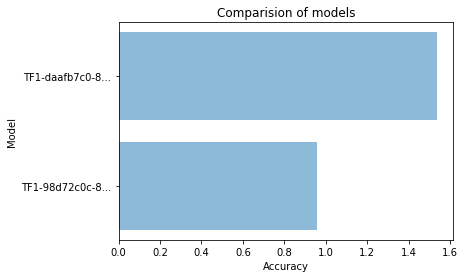

Connection successful
Catalog [KINETICA]
Time 0.205
+----------------------------------------+----------------------+------------------------------+
| model_id                               |             Accuracy |                 time_created |
+----------------------------------------+----------------------+------------------------------+
| 98d72c0c-860a-11e8-a049-984be16d139a   |   0.9580890645662522 |   2018-07-12 19:34:30.000000 |
| daafb7c0-860f-11e8-9c34-984be16d139a   |   1.5387691124673468 |   2018-07-12 20:12:08.000000 |
+----------------------------------------+----------------------+------------------------------+
Rows read = 2
Exec time 0.108 Fetch time 0.038


In [8]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from UDF_util import kineticaIO
import pandas as pd
import gpudb
%matplotlib inline
host_ip="p4.rewreu.org"
PORT = '9191'

h_db = gpudb.GPUdb(encoding='BINARY', host=host_ip,port=PORT)
KIO=kineticaIO.kineticaIO(h_db)
df=pd.DataFrame(KIO.getData(table="TFmodel",offset=0,numberData=100))
df=df[df["model"]=="TF1"]
x=[i+"-"+j[:10]+"..." for i,j in zip(df["model"],df["model_id"])]
objects=tuple(x)
y_pos = np.arange(len(objects))
performance = list(df["Accuracy"])

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Comparision of models')
plt.show()

!./kisql/kisql -h p4.rewreu.org -sql \
"""select model_id,Accuracy, Data_Time_created as time_created from TFmodel where model='TF1' order by Accuracy"""

### Now let's look at the trained Model

<font color='red'>Modify Model_id from last step</font>

double click the import button

In [9]:
from UDF_util import displayModel
import gpudb

host_ip="p4.rewreu.org"
PORT = '9191'

h_db = gpudb.GPUdb(encoding='BINARY', host=host_ip,port=PORT)
displayModel.displayGraphDef(h_db=h_db,
                             Model_id="98d72c0c-860a-11e8-a049-984be16d139a")

### 3. Use last step trained MNIST model for inferencing (distributed UDF)

#### Register and execute UDF_inference.py file

Wait unital it shows: ```Final Proc state: complete```

<font color='red'>Modify Model_id from last step</font>

In [12]:
import gpudb
import collections
import sys
import time
from datetime import datetime, timedelta

# User specified parameters
INPUT_TABLE = 'Mnist_inference'
OUTPUT_TABLE = 'Mnist_inference_out'
COLLECTION='Mnist'
host_ip = "p4.rewreu.org"
modelID="98d72c0c-860a-11e8-a049-984be16d139a"
GPU_memory_allocation_fraction="0.1" # fraction of GPU memory for inference usage, 
#if Kinetica is running on CPU instance, this parameter has no effect

############################
output_type = """
{
   "type": "record",
   "name": "output_type",
   "fields": [
      {"name":"Predict","type":"int"},
      {"name":"Label","type":"int"}
   ]
}  """.replace(' ','').replace('\n','')
output_properties={"Label":["shard_key"]}
#create output predict table
def Create_out_table():
    response = h_db.create_type(type_definition = output_type, label = OUTPUT_TABLE, properties=output_properties)
    if h_db.has_table(table_name = OUTPUT_TABLE)['table_exists']:
       h_db.clear_table(table_name = OUTPUT_TABLE)
    response=h_db.create_table(table_name = OUTPUT_TABLE, type_id = response['type_id'],
                               options={"collection_name":COLLECTION})
    return response

#register UDF
def main():
    proc_name = 'UDF_Mnist_inference'
    filelist=[BASE_dir + "Inference_D_UDF.py",BASE_dir + "kineticaIO.py"] # put the main python script in the first place
    # Read proc code in as bytes and add to a file data array
    files = {}
    for ifile in filelist:
        with open(ifile,'rb') as f:
            files[ifile]=f.read()
    # Connect to Kinetica
    h_db = gpudb.GPUdb(encoding = 'BINARY', host = host_ip, port ="9191")
    # Remove proc if it exists from a prior registration
    if h_db.has_proc(proc_name)['proc_exists']:
        h_db.delete_proc(proc_name)
    print "Registering proc..."
    response = h_db.create_proc(proc_name, 'distributed', files, 'python', [filelist[0],modelID,"127.0.0.1",GPU_memory_allocation_fraction], {})
    #print response

    #Execute UDF
    print "Executing proc..."
    response = h_db.execute_proc(proc_name, {}, {}, [INPUT_TABLE], {}, [OUTPUT_TABLE], {})
    if response['status_info']['status'] == 'OK':
        run_id = response['run_id']
        print('Proc was launched successfully with run_id: ' + run_id)
        start_time = datetime.now()
        while h_db.show_proc_status(run_id)['overall_statuses'][run_id] == 'running':
            time.sleep(1)
            print('process is running, wait... ')
        final_proc_state = h_db.show_proc_status(run_id)['overall_statuses'][run_id]
        print("total running time is ",datetime.now() - start_time)
        print('Final Proc state: ' + final_proc_state)
        if final_proc_state=='error':
            raise RuntimeError('proc error')
    else:
        print('Error launching proc; response: ')
        #print(response)
        raise RuntimeError('proc error')

if __name__=="__main__":
    Create_out_table()
    main()

Registering proc...
Executing proc...
Proc was launched successfully with run_id: 18
process is running, wait... 
process is running, wait... 
process is running, wait... 
process is running, wait... 
process is running, wait... 
process is running, wait... 
process is running, wait... 
('total running time is ', datetime.timedelta(0, 7, 234479))
Final Proc state: complete


# Now lets look at the inferencing result


The distribution of Label result


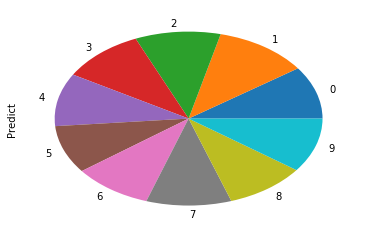

hist plot


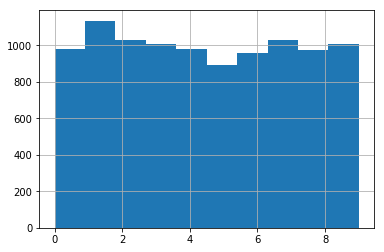

In [13]:
import pandas as pd
from UDF_util import kineticaIO
import matplotlib.pyplot as plt
import gpudb

host_ip="p4.rewreu.org"
PORT = '9191'

h_db = gpudb.GPUdb(encoding='BINARY', host=host_ip,port=PORT)
KIO=kineticaIO.kineticaIO(h_db)
df=pd.DataFrame(KIO.getData(table="Mnist_inference_out",offset=0,numberData=10000))
ldf=df.groupby(['Label']).count()
pdf=df.groupby(['Predict']).count()
print("\nThe distribution of Label result")
ldf["Predict"].plot.pie()
plt.show()
df["Label"].hist()
print("hist plot")
plt.show()


The distribution of Predict result


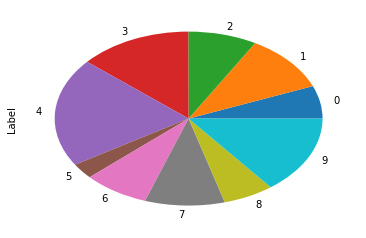

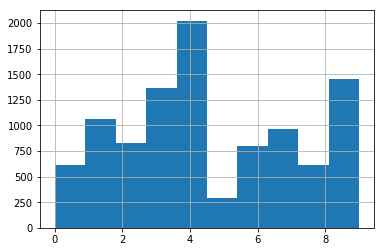

In [14]:
print "\nThe distribution of Predict result"
pdf["Label"].plot.pie()
plt.show()
df["Predict"].hist()
plt.show()

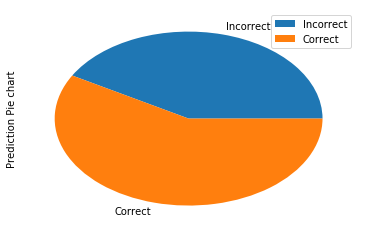

In [15]:
corr=sum(abs(df["Label"]-df["Predict"])==0)
cdf = pd.DataFrame([10**4
                    -corr,corr], index=['Incorrect', 'Correct'],columns=["Prediction Pie chart"])
cdf.plot.pie(subplots=True)
plt.show()

In [16]:
%%bash 
./kisql/kisql -h p4.rewreu.org -sql \
"""
SELECT
    Predict,
    count(*) as count_total,
    sum(case when Predict != Label then 1 else 0 end) as count_incorrect,
    sum(case when Label = Predict then 1 else 0 end) as count_correct
FROM Mnist_inference_out
group by Predict
"""

Connection successful
Catalog [KINETICA]
Time 0.19
+-----------+---------------+-------------------+-----------------+
|   Predict |   count_total |   count_incorrect |   count_correct |
+-----------+---------------+-------------------+-----------------+
|         5 |           287 |               146 |             141 |
|         0 |           609 |               126 |             483 |
|         8 |           615 |               257 |             358 |
|         6 |           796 |               159 |             637 |
|         2 |           830 |               340 |             490 |
|         7 |           963 |               216 |             747 |
|         1 |          1064 |                77 |             987 |
|         3 |          1365 |               613 |             752 |
|         9 |          1449 |               879 |             570 |
|         4 |          2022 |              1363 |             659 |
+-----------+---------------+-------------------+----------------